# Upload dataset kaggle dataset to huggingface 

If the specific Hugging Face dataset with the name `stanpony/european_credit_card_dataset` doesn't exist, we upload the CSV from the Kaggle dataset to Hugging Face. Otherwise, we create it.

In [55]:
from datasets import Dataset, DatasetDict, load_dataset
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load the Hugging Face API token from the .env file
load_dotenv()
hf_api_token = os.getenv('HF_API_TOKEN')

# Log in to Hugging Face
login(token=hf_api_token)

dataset_name = "stanpony/european_credit_card_fraud_dataset"
try:
    # Check if the dataset exists by trying to load the train split
    train_dataset = load_dataset(dataset_name, split='train')
    vali_dataset = load_dataset(dataset_name, split='validation')
    print(f"Dataset {dataset_name} already exists.")
    print("Loaded train and validation splits.")
except:
    import pandas as pd
    from sklearn.model_selection import train_test_split

    # Load the CSV file into a DataFrame
    df = pd.read_csv("data/creditcard.csv")

    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    # Select all rows where Class == 1 (fraud cases)
    df_class_1 = df[df['Class'] == 1].copy()
    df_class_1['original_index'] = df_class_1.index

    # Select 15,000 random rows where Class == 0 (non-fraud cases)
    df_class_0 = df[df['Class'] == 0].sample(n=15000, random_state=42).copy()
    df_class_0['original_index'] = df_class_0.index

    # Reorder columns to make 'original_index' the first column
    df_class_1 = df_class_1[['original_index'] + [col for col in df_class_1.columns if col != 'original_index']]
    df_class_0 = df_class_0[['original_index'] + [col for col in df_class_0.columns if col != 'original_index']]

    # Combine the two dataframes
    new_df = pd.concat([df_class_1, df_class_0]).reset_index(drop=True)

    # Split the dataframe into train and a temporary set (33% of the data), stratifying by 'Class'
    train_df, temp_df = train_test_split(new_df, test_size=0.2, stratify=new_df['Class'], random_state=42)

    # Further split the temporary set into test and validation sets:
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

    # Save the train, test, and validation sets to CSV files
    train_df.to_csv('data/train_creditcard.csv', index=False)
    test_df.to_csv('data/test_creditcard.csv', index=False)
    val_df.to_csv('data/val_creditcard.csv', index=False)

    # Create a dictionary mapping split names to file paths
    data_files = {
        "train": "data/train_creditcard.csv",
        "test": "data/test_creditcard.csv",
        "validation": "data/val_creditcard.csv"
    }

    # Create a DatasetDict with train, test, and validation splits
    dataset = DatasetDict({
        "train": Dataset.from_csv(data_files["train"]),
        "test": Dataset.from_csv(data_files["test"]),
        "validation": Dataset.from_csv(data_files["validation"])
    })

    # Push the dataset to Hugging Face Hub
    dataset.push_to_hub(dataset_name)
    print(f"Dataset {dataset_name} created and uploaded.")

    # Load the train dataset from the Hub for verification
    train_dataset = load_dataset(dataset_name, split='train')
    print(f"Dataset train loaded.")
    vali_dataset = load_dataset(dataset_name, split='validation')
    print(f"Dataset validation loaded.")


Dataset stanpony/european_credit_card_fraud_dataset already exists.
Loaded train and validation splits.


# Train VAE (latent feature extractor)

## Train Fraud VAE

In [ ]:
# Minimal example for training VAE with your existing config file

# Imports
from dataloader import load_fraud_data, load_config
from model_VAE import VariationalAutoEncoder
from trainer import Trainer

# Path to config file
CONFIG_PATH = 'configs/fraud_vae/vae_test.config'

try:
    # 1. Load configuration and data
    config = load_config(CONFIG_PATH)
    data = load_fraud_data(config_path=CONFIG_PATH)

    # 2. Create model from VAE section of config
    model = VariationalAutoEncoder(config['VAE'])

    # 3. Explicitly disable wandb if you don't want to use it
    if 'WandB' not in config:
        config['WandB'] = {}
    config['WandB']['use_wandb'] = False  # Set to True if you want to use wandb

    # 4. Create trainer and train
    trainer = Trainer(model=model, dataloaders=data['dataloaders'], config=config)
    history = trainer.train()

    # 5. Evaluate on test set
    test_metrics = trainer.evaluate_on_test()
    print("\nTest metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.6f}")

except Exception as e:
    # If any error occurs, make sure to clean up wandb
    print(f"An error occurred: {e}")
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    raise e

finally:
    # Always ensure wandb is properly closed
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    print("\nTraining complete!")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded configuration from configs/fraud_vae/vae_test.config


2025-03-05 16:17:10,144 [INFO] Using device: cpu


Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alexkstern/.netrc
wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-03-05 16:17:17,804 [INFO] WandB initialized: project=fraud-vae, run=vae-fraud-training
2025-03-05 16:17:17,809 [INFO] Starting training
Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 28.77it/s, val_loss=959]
2025-03-05 16:17:18,791 [INFO] Saved checkpoint to saved_models/fraud/v1/VariationalAutoEncoder_fraud_20250305-161711_epoch1_val419.7570.pt
2025-03-05 16:17:19,039 [INFO] Epoch 1/50 - Time: 1.23s
2025-03-05 16:17:19,042 [INFO]   Train Loss: 458.753124 (Recon: 453.634746, KL: 5.118378)
2025-03-05 16:17:19,044 [INFO]   Val Loss: 419.757005 (Recon: 404.048797, KL: 15.708206)
Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 27.60it/s, val_loss=727]
2025-03-05 16:17:20,024 [INFO] Saved checkpoint to saved_models/fraud/v1/VariationalAutoEncoder_fraud_20250305-161711_epoch2_val292.4472.pt
2025-03-05 16:17:20,224 [INFO] Epoch 2/50 - Time: 1.18s
2025-03-05 16:17:20,228 [INFO]   Train Loss: 225.687722 (Recon: 216.650211, KL: 9.037511)
2025-03-05 16:17:20,231 [INFO]   Val Loss:

train/kl_loss,▁▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇████████████
train/loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▄▁▂▃▄▄▅▃▅▆▇▆▇▇▅▆█▅▅▄▅▅▇▆▅▆▇▇▇▇▇▆▆▅▆█▄▆▆▅
val/loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂
val/recon_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂
train/kl_loss,16.6289
train/loss,97.43638
train/recon_loss,80.80749
val/kl_loss,16.789
val/loss,87.27973


Testing: 100%|██████████| 6/6 [00:00<00:00, 29.83it/s]

test/loss: 65.655947
test/recon_loss: 52.048761
test/kl_loss: 13.607186


## Train Non-Fraud VAE

In [ ]:
# Minimal example for training VAE with your existing config file

# Imports
from dataloader import load_fraud_data, load_config
from model_VAE import VariationalAutoEncoder
from trainer import Trainer

# Path to config file
CONFIG_PATH = 'configs/non_fraud_vae/vae_test.config'

try:
    # 1. Load configuration and data
    config = load_config(CONFIG_PATH)
    data = load_fraud_data(config_path=CONFIG_PATH)

    # 2. Create model from VAE section of config
    model = VariationalAutoEncoder(config['VAE'])

    # 3. Explicitly disable wandb if you don't want to use it
    if 'WandB' not in config:
        config['WandB'] = {}
    config['WandB']['use_wandb'] = False  # Set to True if you want to use wandb

    # 4. Create trainer and train
    trainer = Trainer(model=model, dataloaders=data['dataloaders'], config=config)
    history = trainer.train()

    # 5. Evaluate on test set
    test_metrics = trainer.evaluate_on_test()
    print("\nTest metrics:")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.6f}")

except Exception as e:
    # If any error occurs, make sure to clean up wandb
    print(f"An error occurred: {e}")
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    raise e

finally:
    # Always ensure wandb is properly closed
    if 'trainer' in locals():
        trainer.cleanup_wandb()
    print("\nTraining complete!")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded configuration from configs/non_fraud_vae/vae_test.config


Filter: 100%|██████████| 12378/12378 [00:00<00:00, 22188.85 examples/s]


Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}


Filter: 100%|██████████| 12378/12378 [00:00<00:00, 22458.19 examples/s]


Filtered dataset to class 0: 12000 samples


Filter: 100%|██████████| 1547/1547 [00:00<00:00, 12679.26 examples/s]


Filtered dataset to class 0: 1500 samples


Filter: 100%|██████████| 1548/1548 [00:00<00:00, 13912.50 examples/s]
2025-03-05 16:33:23,255 [INFO] Using device: cpu


Filtered dataset to class 0: 1500 samples


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alexkstern/.netrc
wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-03-05 16:33:30,742 [INFO] WandB initialized: project=non-fraud-vae, run=vae-fraud-training
2025-03-05 16:33:30,745 [INFO] Starting training
Epoch 1/50 [Val]: 100%|██████████| 47/47 [00:00<00:00, 89.69it/s, val_loss=21]   
2025-03-05 16:33:35,936 [INFO] Saved checkpoint to saved_models/non_fraud/v1/VariationalAutoEncoder_non-fraud_20250305-163324_epoch1_val21.2505.pt
2025-03-05 16:33:36,179 [INFO] Epoch 1/50 - Time: 5.43s
2025-03-05 16:33:36,182 [INFO]   Train Loss: 25.413530 (Recon: 20.682736, KL: 4.730794)
2025-03-05 16:33:36,185 [INFO]   Val Loss: 21.250500 (Recon: 14.804658, KL: 6.445842)
Epoch 2/50 [Val]: 100%|██████████| 47/47 [00:00<00:00, 83.15it/s, val_loss=19.5] 
2025-03-05 16:33:41,455 [INFO] Saved checkpoint to saved_models/non_fraud/v1/VariationalAutoEncoder_non-fraud_20250305-163324_epoch2_val20.2577.pt
2025-03-05 16:33:41,638 [INFO] Epoch 2/50 - Time: 5.45s
2025-03-05 16:33:41,640 [INFO]   Train Loss: 21.398632 (Recon: 15.004497, KL: 6.394135)
2025-03-05 16:33:41,641

train/kl_loss,▁▆▇█████
train/loss,█▄▃▂▂▂▁▁
train/recon_loss,█▄▃▂▂▁▁▁
val/kl_loss,▁▃▂▆▆▅█▇
val/loss,█▆▃▂▂▁▂▂
val/recon_loss,█▆▃▂▂▁▁▁
train/kl_loss,6.91507
train/loss,18.74769
train/recon_loss,11.83262
val/kl_loss,7.61146
val/loss,18.47719


Testing:   2%|▏         | 1/47 [00:00<00:14,  3.19it/s]


AttributeError: 'NoneType' object has no attribute '_log'

## Build classifier with trained latent Feature

In [8]:
# Simple script to load VAE dataset without the original data

import numpy as np
import pandas as pd
import os

# Directory with the VAE dataset
data_dir = 'vae_dataset'

# Select which split to visualize
split = 'train'  # Options: 'train', 'val', 'test'

# Load the data
print(f"Loading {split} dataset...")
X = np.load(os.path.join(data_dir, f'{split}_combined_features.npy'))
feature_names = np.load(os.path.join(data_dir, f'{split}_feature_names.npy'), allow_pickle=True)
labels = np.load(os.path.join(data_dir, f'{split}_labels.npy'))

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=feature_names)

# Add label column
df['label'] = labels

# Display basic information
print(f"DataFrame shape: {df.shape}")

# Display the head of the DataFrame
df.head()

Loading train dataset...
DataFrame shape: (12378, 23)


,fraud_latent_0,fraud_latent_1,fraud_latent_2,fraud_latent_3,fraud_latent_4,fraud_latent_5,fraud_latent_6,fraud_latent_7,fraud_latent_8,fraud_latent_9,...,non_fraud_latent_2,non_fraud_latent_3,non_fraud_latent_4,non_fraud_latent_5,non_fraud_latent_6,non_fraud_latent_7,non_fraud_latent_8,non_fraud_latent_9,non_fraud_recon_error,label
0,-0.615643,0.751735,-0.404673,0.545401,-0.288656,-0.766497,0.099406,2.070422,0.142465,-0.773488,...,0.169732,-0.540064,0.177553,-0.771990,-1.690295,-1.534132,-2.203338,0.374561,0.354833,0
1,-1.250439,0.235100,0.025312,-0.269650,-0.987701,-0.920562,-0.994900,1.402146,-0.038242,0.495690,...,-0.518433,-0.979053,1.128486,-0.038908,0.519204,0.301190,0.725730,-0.704731,0.105169,0
2,-1.041233,1.005673,-0.295047,-0.495441,-0.633346,-0.538213,-0.912619,1.734814,0.155106,-0.067113,...,-0.645789,1.043757,-0.616265,0.510356,-0.252283,-0.158109,-0.577012,0.256973,0.280511,0
3,-1.411137,0.593400,-0.428755,0.556435,-0.720047,-0.651324,-0.310020,2.148195,-0.593145,-0.470835,...,-0.988748,-0.495142,0.539933,-0.649971,0.252956,1.011837,-0.883104,1.754187,0.570871,0
4,-0.627044,0.368182,-0.246027,-0.848488,-0.669438,-0.823566,-0.687639,2.041727,0.406208,-0.008551,...,0.859374,0.759472,-0.138708,0.008946,-0.660882,-1.112314,-0.496360,-0.240784,0.230561,0


Loading train dataset...
Loading test dataset...
Train VAE features shape: (12378, 22)
Train original features shape: (12378, 30)
Train labels shape: (12378,)
Test VAE features shape: (1548, 22)
Test original features shape: (1548, 30)
Test labels shape: (1548,)

Training MLP on VAE features...


/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training completed in 18.07 seconds

Training MLP on original features...
Training completed in 2.61 seconds

Evaluating MLP with VAE features on test set...
Accuracy (VAE features): 0.9432
ROC AUC (VAE features): 0.2749
Classification Report (VAE features):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1500
           1       0.10      0.10      0.10        48

    accuracy                           0.94      1548
   macro avg       0.54      0.54      0.54      1548
weighted avg       0.94      0.94      0.94      1548


Evaluating MLP with original features on test set...
Accuracy (original features): 0.9690
ROC AUC (original features): 0.6034
Classification Report (original features):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1548
   macro avg       0.48   

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

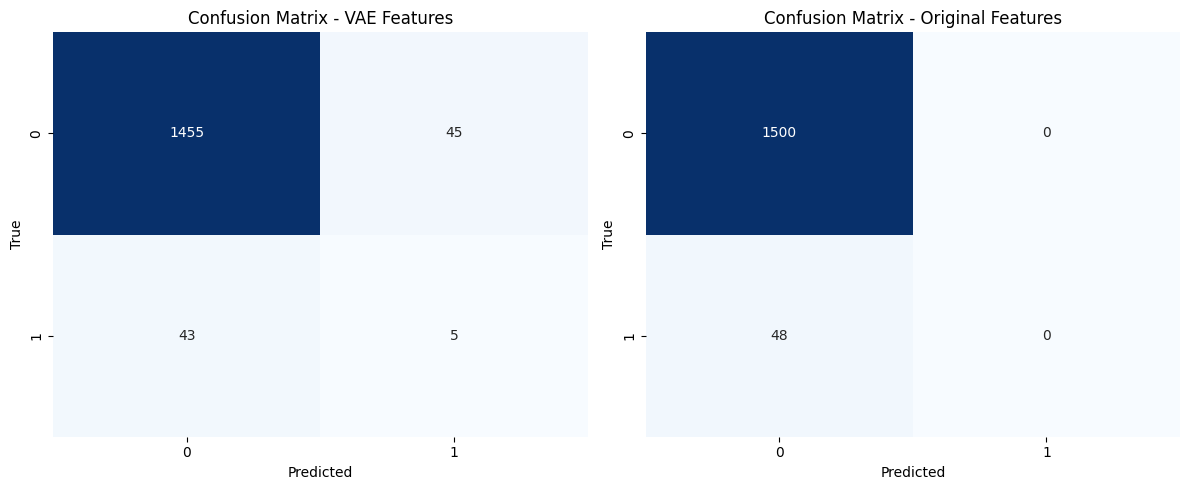

In [10]:
# MLP Classifier Comparison: VAE Features vs Original Features

import numpy as np
import pandas as pd
import os
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Directory with the VAE dataset
data_dir = 'vae_dataset'

# Load train data
print("Loading train dataset...")
X_train_vae = np.load(os.path.join(data_dir, 'train_combined_features.npy'))
feature_names = np.load(os.path.join(data_dir, 'train_feature_names.npy'), allow_pickle=True)
y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
X_train_original = np.load(os.path.join(data_dir, 'train_original_data.npy'))

# Load test data
print("Loading test dataset...")
X_test_vae = np.load(os.path.join(data_dir, 'test_combined_features.npy'))
y_test = np.load(os.path.join(data_dir, 'test_labels.npy'))
X_test_original = np.load(os.path.join(data_dir, 'test_original_data.npy'))

# Print dataset shapes
print(f"Train VAE features shape: {X_train_vae.shape}")
print(f"Train original features shape: {X_train_original.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test VAE features shape: {X_test_vae.shape}")
print(f"Test original features shape: {X_test_original.shape}")
print(f"Test labels shape: {y_test.shape}")

# Create and train MLP on VAE features
print("\nTraining MLP on VAE features...")
start_time = time()
mlp_vae = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)
mlp_vae.fit(X_train_vae, y_train)
vae_training_time = time() - start_time
print(f"Training completed in {vae_training_time:.2f} seconds")

# Create and train MLP on original features
print("\nTraining MLP on original features...")
start_time = time()
mlp_original = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)
mlp_original.fit(X_train_original, y_train)
original_training_time = time() - start_time
print(f"Training completed in {original_training_time:.2f} seconds")

# Evaluate on test set - VAE features
print("\nEvaluating MLP with VAE features on test set...")
y_pred_vae = mlp_vae.predict(X_test_vae)
y_pred_proba_vae = mlp_vae.predict_proba(X_test_vae)[:, 1]

accuracy_vae = accuracy_score(y_test, y_pred_vae)
roc_auc_vae = roc_auc_score(y_test, y_pred_proba_vae)
report_vae = classification_report(y_test, y_pred_vae)

print(f"Accuracy (VAE features): {accuracy_vae:.4f}")
print(f"ROC AUC (VAE features): {roc_auc_vae:.4f}")
print("Classification Report (VAE features):")
print(report_vae)

# Evaluate on test set - Original features
print("\nEvaluating MLP with original features on test set...")
y_pred_original = mlp_original.predict(X_test_original)
y_pred_proba_original = mlp_original.predict_proba(X_test_original)[:, 1]

accuracy_original = accuracy_score(y_test, y_pred_original)
roc_auc_original = roc_auc_score(y_test, y_pred_proba_original)
report_original = classification_report(y_test, y_pred_original)

print(f"Accuracy (original features): {accuracy_original:.4f}")
print(f"ROC AUC (original features): {roc_auc_original:.4f}")
print("Classification Report (original features):")
print(report_original)

# Compare results
print("\n=== Performance Comparison ===")
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC', 'Training Time (s)'],
    'VAE Features': [accuracy_vae, roc_auc_vae, vae_training_time],
    'Original Features': [accuracy_original, roc_auc_original, original_training_time]
})
print(comparison)

# Create confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_vae = confusion_matrix(y_test, y_pred_vae)
sns.heatmap(cm_vae, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - VAE Features')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_original = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Original Features')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()